In [83]:
%matplotlib inline

# general
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Geographical analysis
import pandas_geojson as geo_pd
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
#import shapefile as shp
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import requests
import missingno as msno
#import descartes

# accessibility analysis
import time
#from pandana.loaders import osm
#from pandana.loaders import pandash5

# modelling
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# Set plot preference
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print('Libraries imported.')

Libraries imported.


In [84]:
listings = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/listings.csv.gz')

In [85]:
calendar = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/calendar.csv.gz')

In [86]:
neighbourhoods = geo_pd.read_geojson_url('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/neighbourhoods.geojson')

In [87]:
neighbourhoods = geo_pd.read_geojson_url('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2022-2023/airbnb/neighbourhoods.geojson')

<AxesSubplot:>

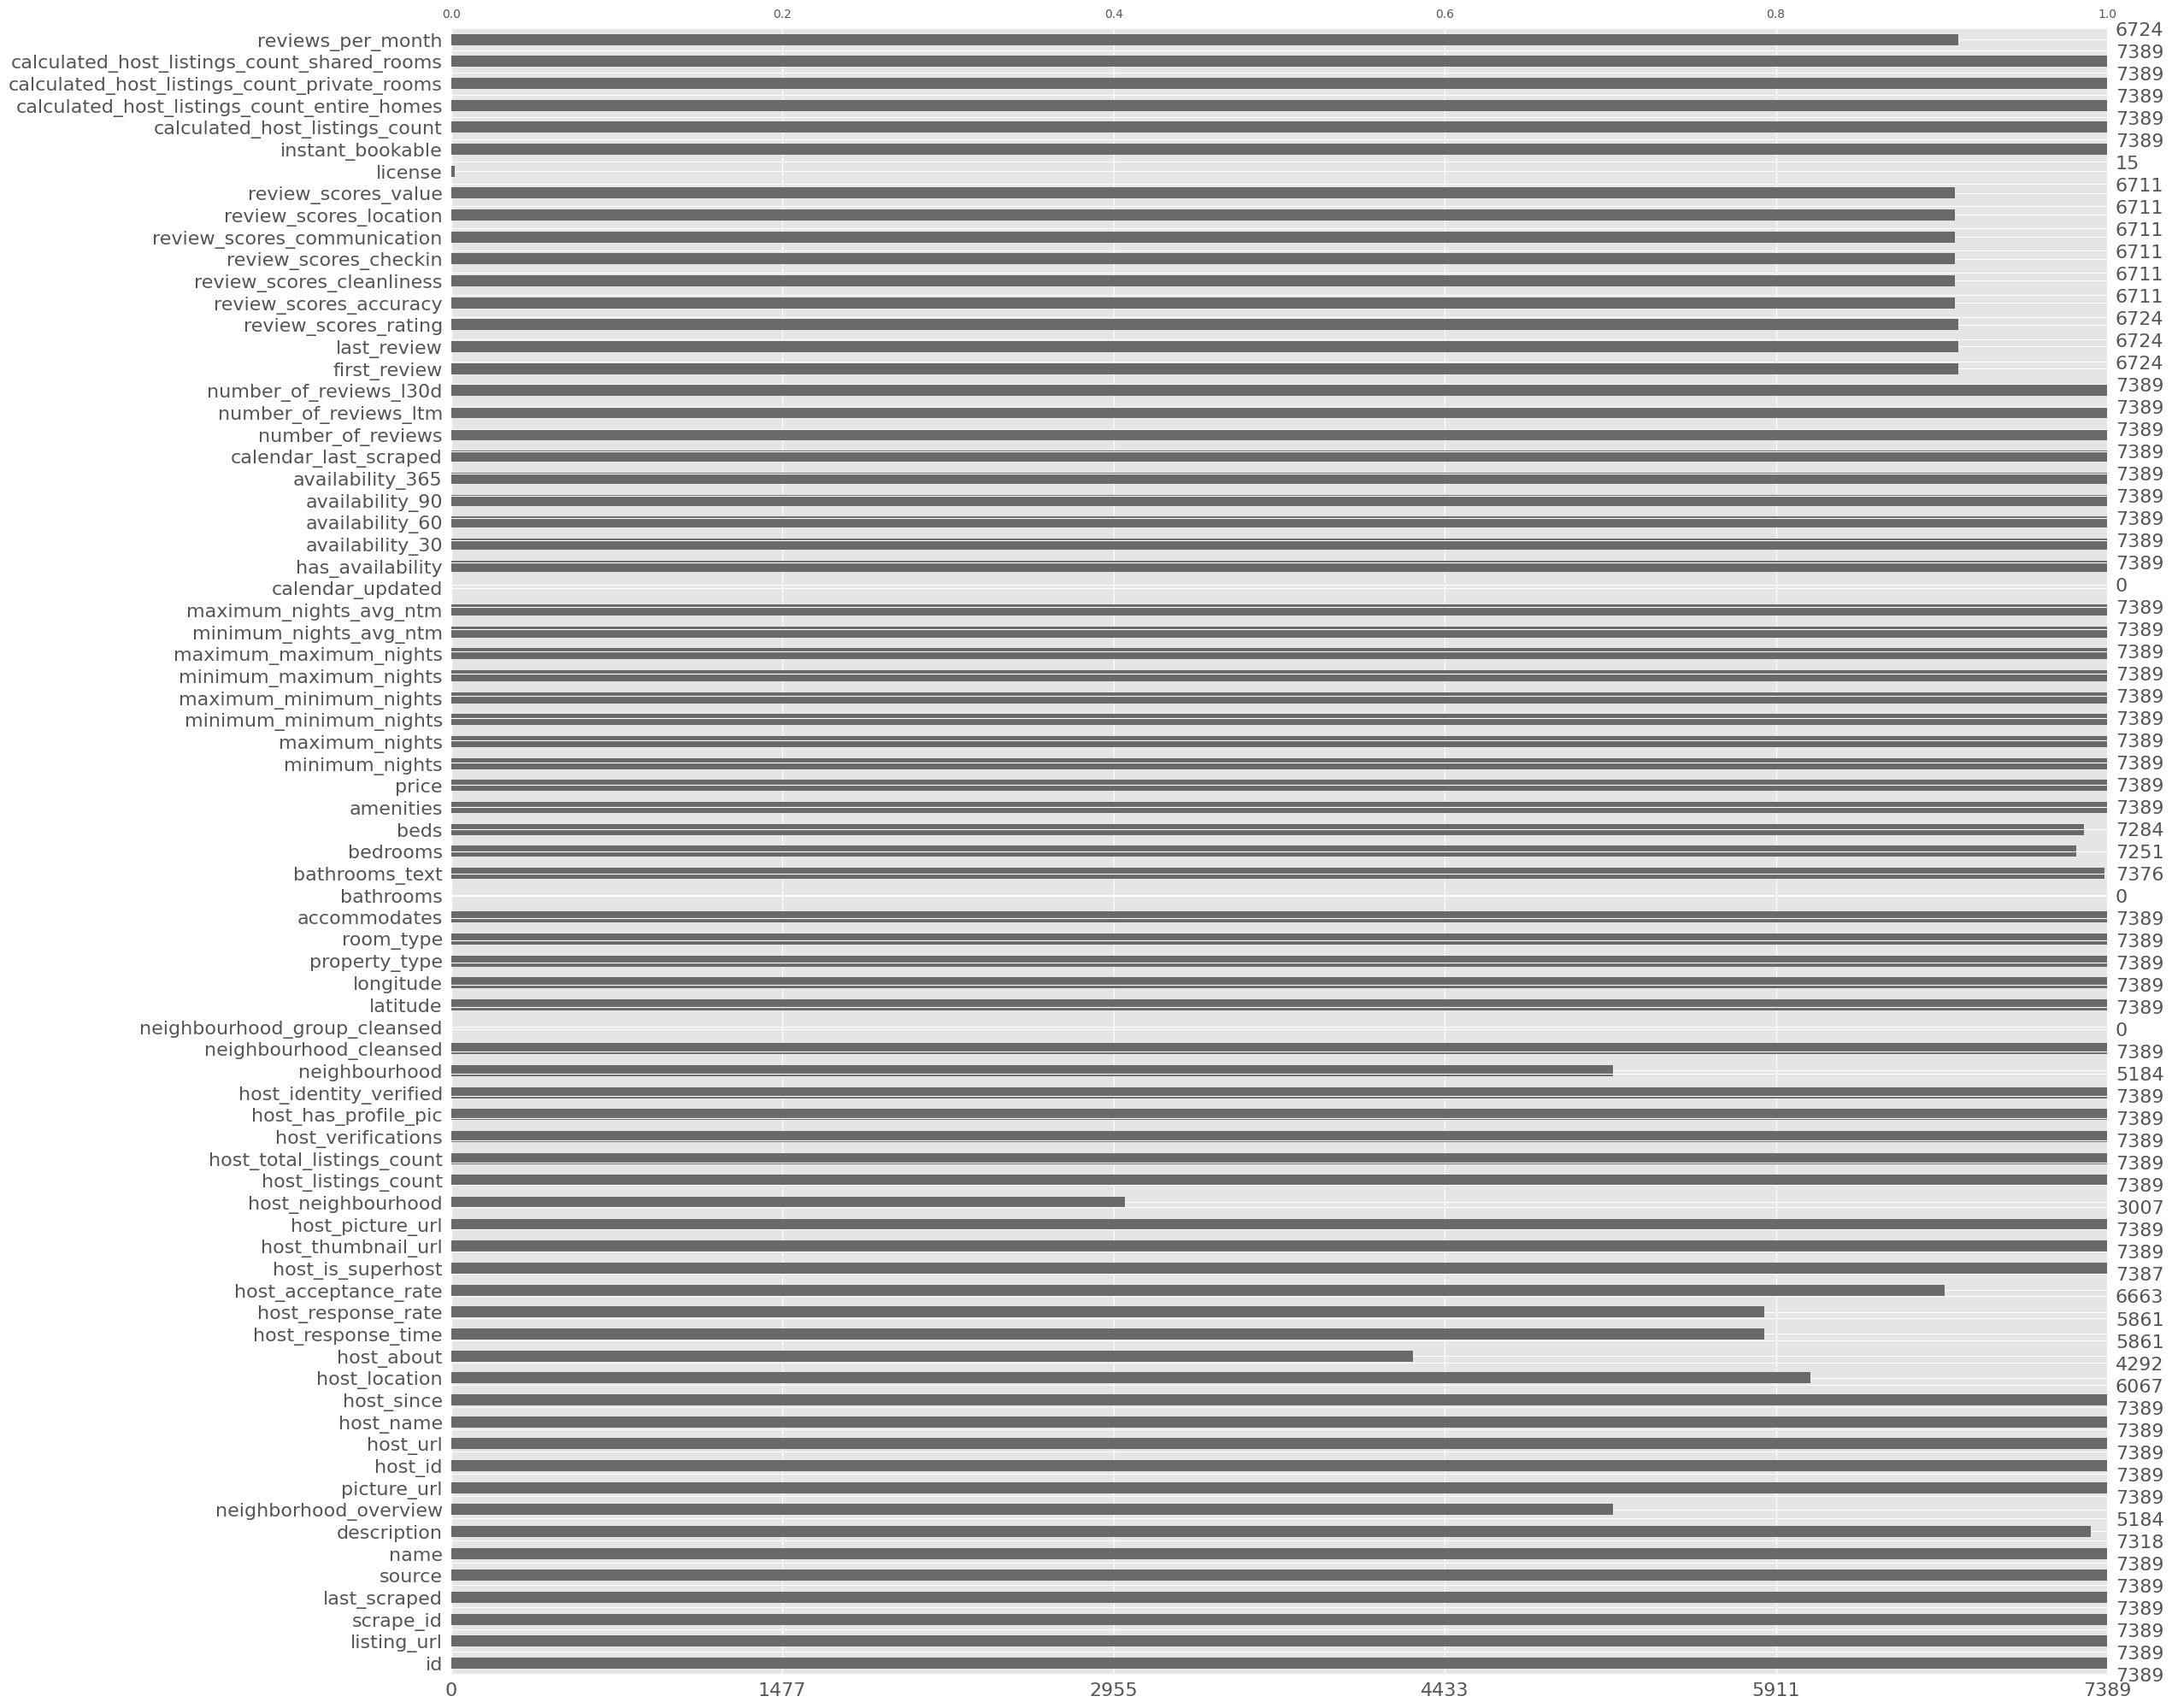

In [88]:
# CLEANING LISTINGS

msno.bar(listings)

give reasons for why we are dropping cols

In [89]:
clean_listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 
                  'name', 'description', 'source', 'neighbourhood', 'neighbourhood_group_cleansed',
                  'neighborhood_overview',  'picture_url', 
                  'host_id', 'host_url', 'host_name', 'license',
                  'host_location', 'host_about', 'host_thumbnail_url', 
                  'host_picture_url', 'host_neighbourhood', 'host_verifications', 
                  'calendar_last_scraped', 'calendar_updated']
                    , axis=1)

In [90]:
pd.set_option('display.max_columns', len(clean_listings.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
clean_listings.head(3)

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,15420,2009-12-06,within a few hours,100%,96%,t,3,6,t,t,"Old Town, Princes Street and Leith Street",55.95759,-3.18805,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Self check-in"", ""Hot water kettle"", ""Private...",$114.00,3,30,1,3,30,30,3.0,30.0,t,5,22,35,187,450,73,4,2011-01-18,2022-11-29,4.97,4.98,4.96,4.97,4.98,4.98,4.91,f,1,1,0,0,3.10
1,707097,2012-07-29,within a day,50%,84%,f,9,16,t,t,"Old Town, Princes Street and Leith Street",55.94980,-3.18354,Entire condo,Entire home/apt,9,NaN,2 baths,3.0,7.0,"[""TV with standard cable"", ""Stove"", ""Self chec...",$598.00,2,1000,28,300,1125,1125,104.3,1125.0,t,0,4,4,210,67,7,0,2013-01-03,2022-09-22,4.38,4.32,4.40,4.69,4.72,4.94,4.09,t,8,6,2,0,0.55
2,728199,2012-10-06,within an hour,100%,95%,t,1,2,t,t,Polwarth,55.93692,-3.22414,Private room in rental unit,Private room,3,NaN,1 private bath,1.0,1.0,"[""Self check-in"", ""Stove"", ""Bed linens"", ""Chil...",$60.00,1,14,1,4,14,14,1.3,14.0,t,6,24,49,195,354,52,2,2012-10-22,2022-12-04,4.82,4.86,4.81,4.95,4.97,4.73,4.79,f,1,0,1,0,2.86


In [91]:
clean_listings.isna().sum()

id                                                 0
host_since                                         0
host_response_time                              1528
host_response_rate                              1528
host_acceptance_rate                             726
host_is_superhost                                  2
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                       7389
bathrooms_text                                    13
bedrooms                                      

### FILLING DATA

In [92]:
# Extracting number of bathrooms from bathroom text
clean_listings['bathrooms'] = clean_listings['bathrooms_text'].str.extract(r'([\d.])').astype(float)
clean_listings.drop(['bathrooms_text'] , axis=1, inplace=True)

NEED TO CHANGE!!
There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.


In [93]:
clean_listings.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 
                    'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'host_is_superhost'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>,
        <AxesSubplot:title={'center':'host_has_profile_pic'}>,
        <AxesSubplot:title={'center':'host_identity_verified'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'beds'}>],
       [<AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>,
        <AxesSubplot:title={'center':'has_availability'}>,
        <AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_60'}>,
        <AxesSubplot:title={'center':'

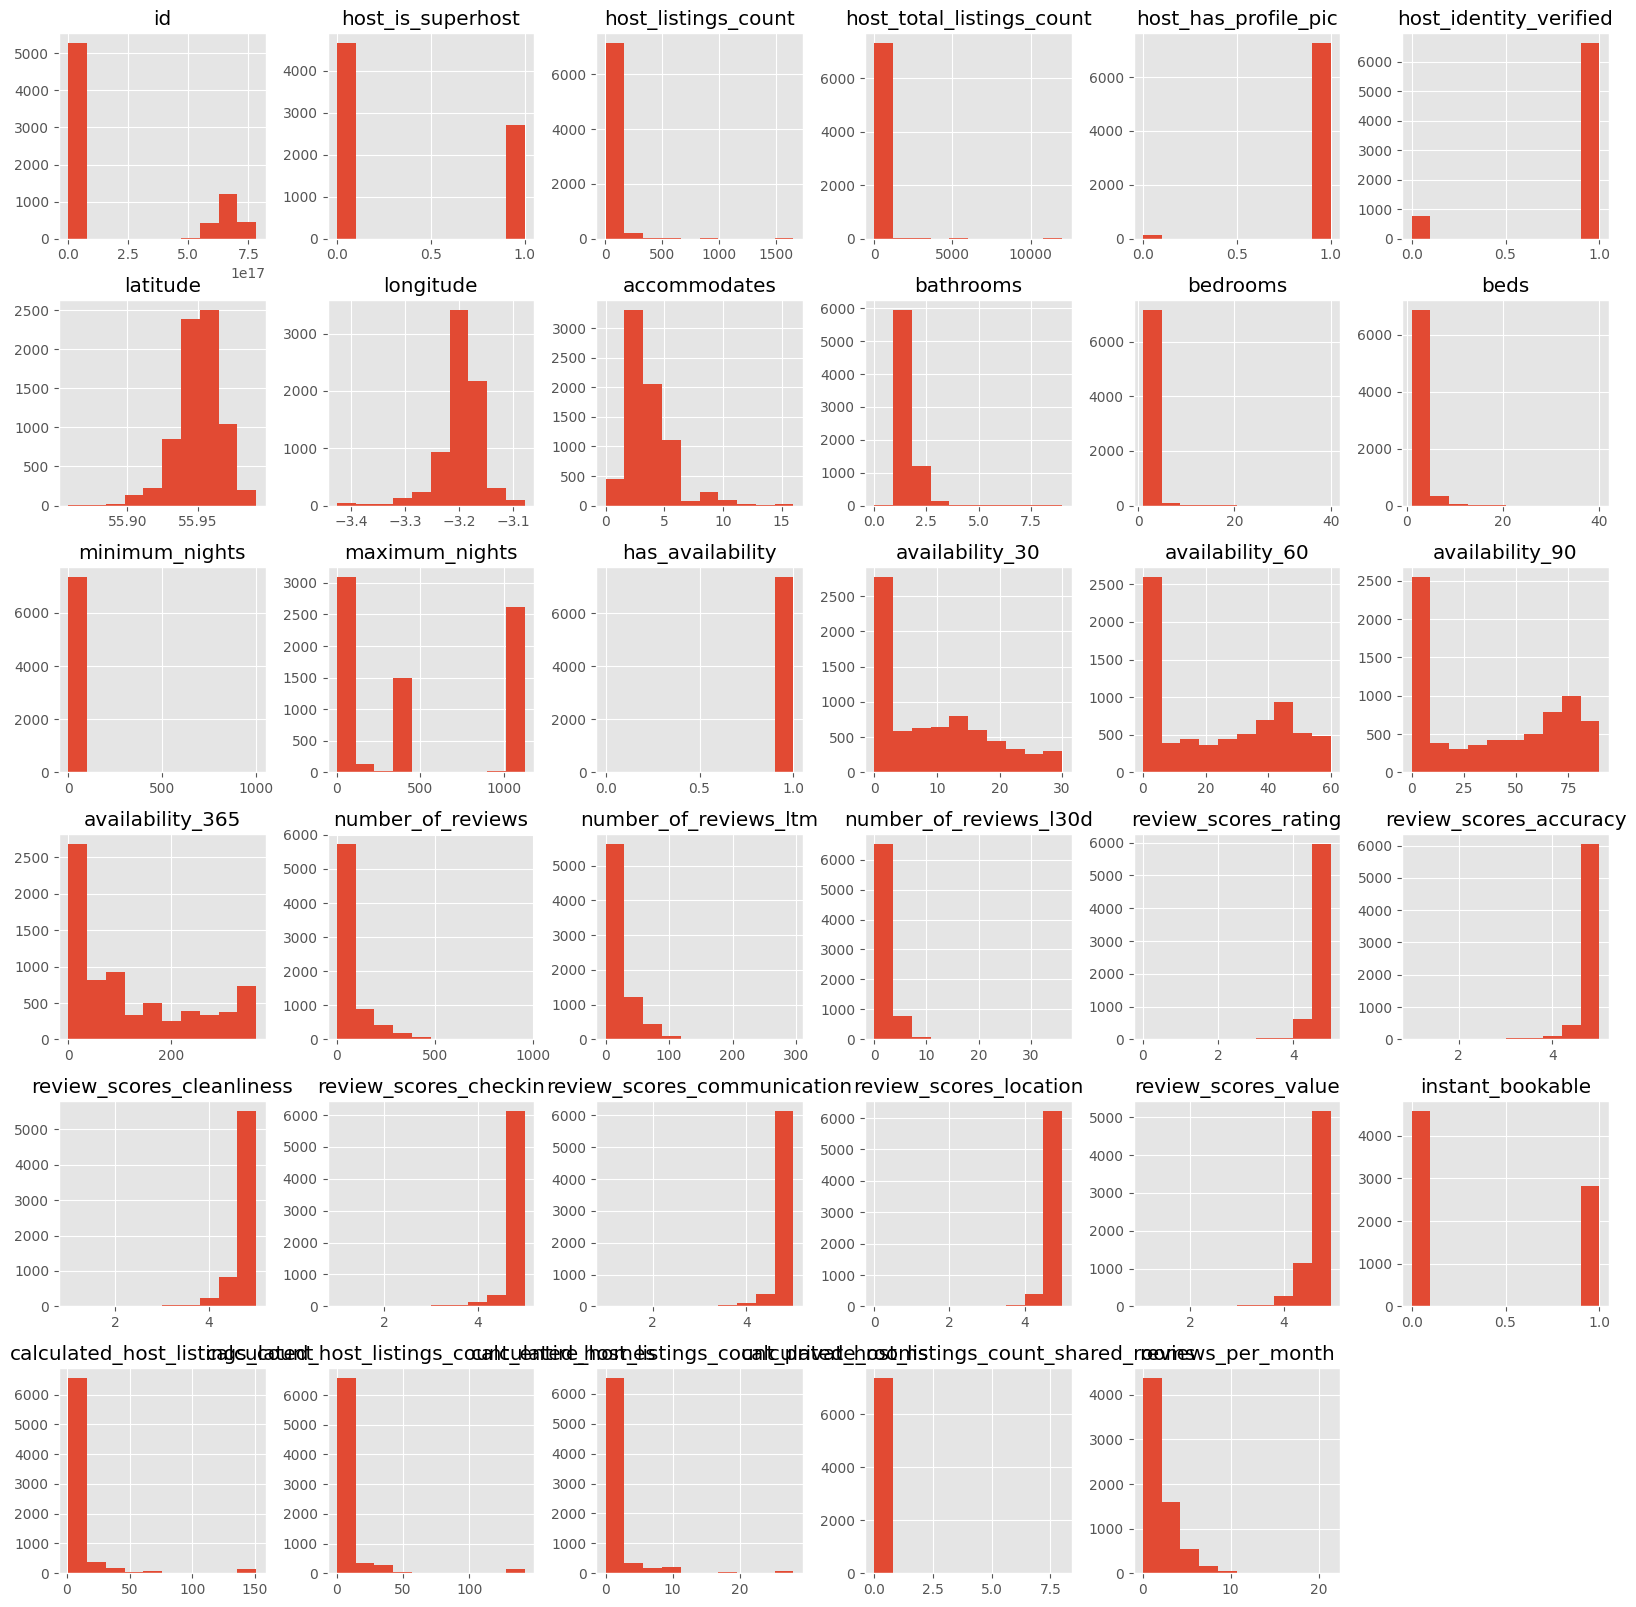

In [94]:
# Replacing columns with f/t with 0/1
clean_listings.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
clean_listings.hist(figsize=(20,20))

In [95]:
clean_listings.drop(['has_availability', 'host_has_profile_pic'], axis=1, inplace=True)

In [96]:
# Converting to datetime
clean_listings.host_since = pd.to_datetime(clean_listings.host_since) 

# Calculating the number of days
clean_listings['host_days_active'] = (pd.datetime(2023, 3, 19) - clean_listings.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(clean_listings['host_days_active'].mean(),0))
print("Median days as host:", clean_listings['host_days_active'].median())

# Replacing null values with the median
clean_listings.host_days_active.fillna(clean_listings.host_days_active.median(), inplace=True)

Mean days as host: 2326.0
Median days as host: 2476.0


/tmp/ipykernel_31144/620780894.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  clean_listings['host_days_active'] = (pd.datetime(2023, 3, 19) - clean_listings.host_since).astype('timedelta64[D]')


In [97]:
print("Null values:", clean_listings.host_response_time.isna().sum())
print(f"Proportion: {round((clean_listings.host_response_time.isna().sum()/len(clean_listings))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(clean_listings[clean_listings.loc[ :,['host_response_time', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 1528
Proportion: 20.7%


215

In [98]:
clean_listings.host_response_time.fillna("unknown", inplace=True)
clean_listings.host_response_time.value_counts(normalize=True)

within an hour        0.622682
unknown               0.206794
within a few hours    0.089728
within a day          0.065097
a few days or more    0.015699
Name: host_response_time, dtype: float64

In [99]:
clean_listings.host_response_time.value_counts(normalize=True)

within an hour        0.622682
unknown               0.206794
within a few hours    0.089728
within a day          0.065097
a few days or more    0.015699
Name: host_response_time, dtype: float64

In [100]:
print("Null values:", clean_listings.host_response_rate.isna().sum())
print(f"Proportion: {round((clean_listings.host_response_rate.isna().sum()/len(clean_listings))*100, 1)}%")

Null values: 1528
Proportion: 20.7%


In [101]:
# Removing the % sign from the host_response_rate string and converting to an integer
clean_listings['host_response_rate'] = clean_listings['host_response_rate'].str.rstrip('%').astype('float')

print("Mean host response rate:", round(clean_listings['host_response_rate'].mean(),2))
print("Median host response rate:", clean_listings['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((clean_listings.host_response_rate == 100).sum()/clean_listings.host_response_rate.count())*100,1)}%")

Mean host response rate: 95.9
Median host response rate: 100.0
Proportion of 100% host response rates: 77.7%


In [102]:
# Bin into four categories
clean_listings.host_response_rate = pd.cut(clean_listings.host_response_rate, 
                               bins=[0, 50, 90, 99, 100], 
                               labels=['0-49%', '50-89%', '90-99%', '100%'], 
                               include_lowest=True)

# Converting to string
clean_listings.host_response_rate = clean_listings.host_response_rate.astype('str')

# Replace nulls with 'unknown'
clean_listings.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
clean_listings.host_response_rate.value_counts()

100%       4554
unknown    1528
90-99%      629
50-89%      524
0-49%       154
Name: host_response_rate, dtype: int64

In [104]:
# Number of rows without a value for multiple host-related columns
len(clean_listings[clean_listings.loc[ :,['host_since', 'host_is_superhost', 'host_listings_count', 
                  'host_identity_verified'] ].isnull().sum(axis=1) == 4])

0